## 📥 Data Collection: Apple Stock Prices

For this time series forecasting project, we use **Apple Inc. (AAPL)** stock data as it is one of the most stable and well-known stocks in the market.

We utilize the `yfinance` library to pull daily historical data from **January 1, 2010 to the present**. The dataset includes the following features:
- `Open`: Price at market open
- `High`: Highest price during the day
- `Low`: Lowest price during the day
- `Close`: Price at market close
- `Adj Close`: Price adjusted for dividends/splits
- `Volume`: Number of shares traded

This data will be used to train a forecasting model (ARIMA or LSTM) to predict future stock prices.

[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.440331  6.455077  6.391279  6.422877  493729600
2010-01-05  6.451465  6.487878  6.417459  6.458086  601904800
2010-01-06  6.348848  6.477047  6.342227  6.451467  552160000
2010-01-07  6.337108  6.379841  6.291065  6.372318  477131200
2010-01-08  6.379241  6.379843  6.291368  6.328683  447610800


<Figure size 1200x600 with 0 Axes>

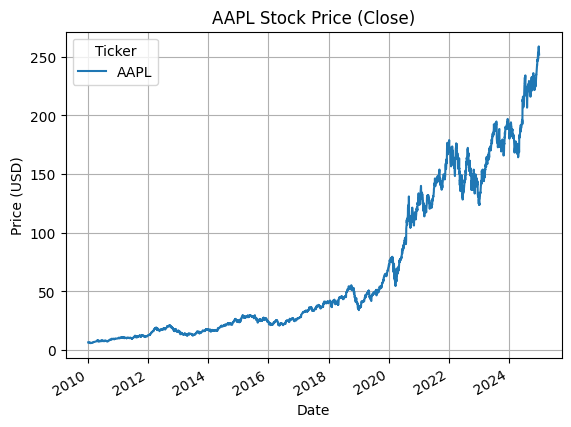

In [12]:
# Install yfinance if not already installed
# !pip install yfinance

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the stock ticker and time range
ticker = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-12-31'

# Fetch data
df = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
print(df.head())

# Plot the closing price
plt.figure(figsize=(12, 6))
df['Close'].plot()
plt.title(f'{ticker} Stock Price (Close)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

## 📊 Exploratory Data Analysis (EDA)

Before choosing a forecasting model, it's important to understand the stock's behavior over time. Key steps include:

1. **Visual Inspection**:
   - Plot the `Close` prices to spot overall trend, seasonality, or volatility.
2. **Rolling Mean and Standard Deviation**:
   - Useful for checking stationarity.
3. **Distribution Plot**:
   - Helps visualize the spread and skewness of price changes.
4. **ADF Test (Augmented Dickey-Fuller)**:
   - A statistical test to check if the time series is stationary or not.

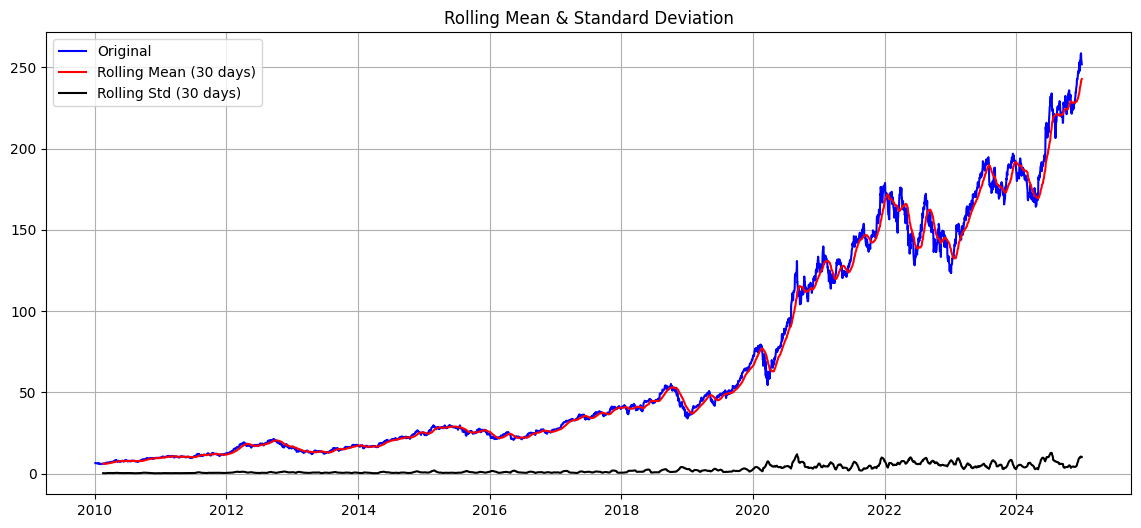

ADF Test Results:
ADF Statistic : 1.7639911503481236
p-value       : 0.9982748605367605
Critical Value 1% : -3.432093147877892
Critical Value 5% : -2.862310226612903
Critical Value 10% : -2.5671800022025875


In [13]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Plot rolling mean and standard deviation
rolling_mean = df['Close'].rolling(window=30).mean()
rolling_std = df['Close'].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='red')
plt.plot(rolling_std, label='Rolling Std (30 days)', color='black')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.grid(True)
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['Close'].dropna())
print("ADF Test Results:")
print(f"ADF Statistic : {adf_result[0]}")
print(f"p-value       : {adf_result[1]}")
for key, value in adf_result[4].items():
    print(f"Critical Value {key} : {value}")

## 🔁 Differencing the Series

To make the time series stationary (a requirement for ARIMA), we apply **first-order differencing**. This removes trends and stabilizes the mean. After differencing, we’ll re-run the ADF test to verify stationarity.

In [16]:
print(df_diff.columns)


Index(['AAPL'], dtype='object', name='Ticker')


## Step 4: Determine ARIMA Parameters using ACF & PACF

To configure the ARIMA model, we need to determine the optimal values of:
- **p** (autoregressive terms),
- **d** (differencing order), and
- **q** (moving average terms).

We've already chosen **d = 1** after making the series stationary.

Now, we'll use the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots to determine suitable values for **p** and **q**.

### Interpretation Guidelines:
- ACF helps identify the **q** parameter.
- PACF helps identify the **p** parameter.
- We'll analyze the lag after which the plot drops off significantly.

KeyError: 'Close'

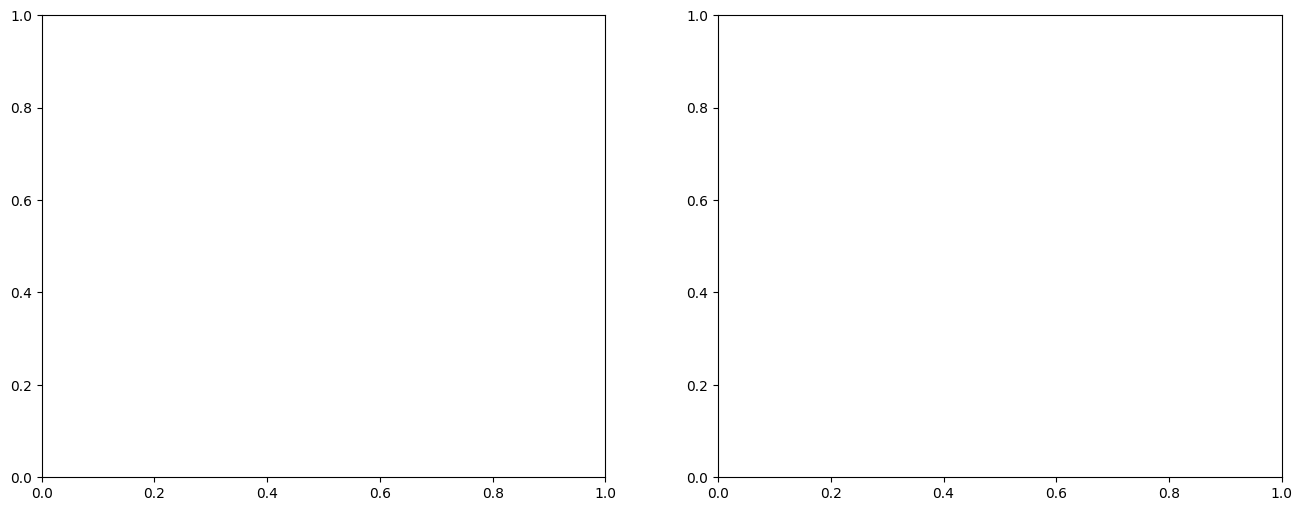

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(df_diff['Close'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df_diff['Close'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()